### The objective of this project is to identify which of these predictor variables a has a significant importance on the insurance sharges that an insurance company pays out.

#### We will use stasmodel's OLS model and sklearn's Random Forest Regressor to determine if there will be a difference in their reults on which of the variables is  most important.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
insurance = pd.read_csv("E:\PROGRAMMING\insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### We do not have any missing data so we are not worried about filling.

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
encoder = OneHotEncoder(drop = 'first')
categorical = insurance[['sex', 'smoker', 'region']]
insurance_encoded = encoder.fit_transform(categorical)
insurance_encoded = pd.DataFrame(insurance_encoded.toarray(), columns = encoder.get_feature_names_out())
insurance_encoded = pd.concat([insurance, insurance_encoded], axis = 1)
insurance_encoded.drop(columns = ['sex', 'smoker', 'region'], inplace =True)
insurance_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
insurance_scaled = scaler.fit_transform(insurance_encoded)
insurance_scaled = pd.DataFrame(insurance_scaled, columns = insurance_encoded.columns)

In [8]:
insurance_scaled.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.298584,-1.010519,1.970587,-0.566418,-0.611324,1.765481
1,-1.509965,0.509621,-0.078767,-0.953689,0.989591,-0.507463,-0.566418,1.635795,-0.566418
2,-0.797954,0.383307,1.580926,-0.728675,0.989591,-0.507463,-0.566418,1.635795,-0.566418
3,-0.441948,-1.305531,-0.908614,0.719843,0.989591,-0.507463,1.765481,-0.611324,-0.566418
4,-0.513149,-0.292556,-0.908614,-0.776802,0.989591,-0.507463,1.765481,-0.611324,-0.566418


In [9]:
correlation = insurance_scaled.corr()
correlation_charges = correlation['charges'].sort_values(ascending = False)
correlation_charges

charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64

From this correlation, we find out that a a client who smokes has a high correlation with high insurance charges. However correlation does not mean causation so we move forward with identifying other possible predictor variables.

In [10]:
import seaborn as sns

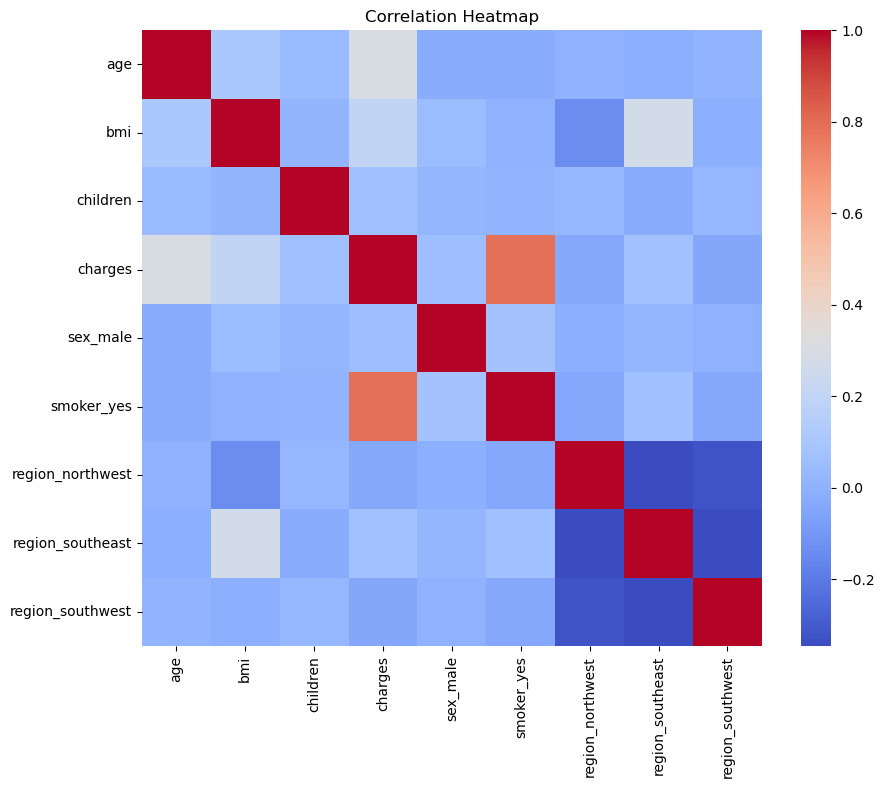

In [11]:
plt.figure(figsize = (10,8))
sns.heatmap(correlation, annot = False, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
X = insurance_scaled.drop(columns = ['charges'], axis = 1)
y = insurance_scaled['charges']

import statsmodels.api as sm

model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.751
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              501.2
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        17:30:47   Log-Likelihood:                         -968.66
No. Observations:                1338   AIC:                                      1953.
Df Residuals:                    1330   BIC:                                      1995.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

It is important to notice that in this case we did not get a warning of multicollinearity which was expected since our sex column had a direct correlation of 0 and 1 for female and male respectively. We will therefore reduce our variables depending on the importance of features on our target variable.

We also notice that we got an uncentered R2 becasue we did not add a constant to our independent variables. It is good practice to do so, because it allows the model to estimate both the slope (coefficients) and the intercept of the regression line. In many real-world scenarios, it's rare for the relationship between variables to pass through the origin. Therefore, including a constant term allows the model to better capture the overall trend and variation in the data.

In [13]:
from scipy.stats import pearsonr

In [14]:
dict_cp = {}
column_titles = [col for col in correlation.index if col != 'charges']

for col in column_titles:
    p_val = round(pearsonr(insurance_scaled[col], insurance_scaled['charges'])[1], 6)
    dict_cp[col] = {'Correlation_coefficient': correlation.loc['charges', col],
                    'P_Value': p_val}

insurance_scaled_cp = pd.DataFrame(dict_cp).T
insurance_scaled_cp = insurance_scaled_cp.sort_values('Correlation_coefficient')
significant_correlations = insurance_scaled_cp[insurance_scaled_cp['P_Value'] < 0.05]
print(significant_correlations)

                  Correlation_coefficient   P_Value
sex_male                         0.057292  0.036133
children                         0.067998  0.012852
region_southeast                 0.073982  0.006783
bmi                              0.198341  0.000000
age                              0.299008  0.000000
smoker_yes                       0.787251  0.000000


The above features are below our significance level of 0.05 and have higher correlation coefficient as compared to the unlisted  2 features. 

In [15]:
high_autocorrelation_vars = []

# Threshold for high autocorrelation
autocorrelation_threshold = 0.5  # Adjust as needed

# Compute autocorrelation for each significant variable
for var in significant_correlations.index:
    autocorr = insurance_scaled[var].autocorr()
    if abs(autocorr) > autocorrelation_threshold:
        high_autocorrelation_vars.append(var)
        print(f"Variable '{var}' has high autocorrelation: {autocorr}")

print("Variables with high autocorrelation:", high_autocorrelation_vars)

Variables with high autocorrelation: []


None of our features are autocorrelated

In [16]:
important_features = insurance_scaled[['age', 'bmi', 'smoker_yes', 'region_southeast', 'children', 'sex_male']]

X = important_features
y = insurance_scaled['charges']

model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              666.5
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        17:30:47   Log-Likelihood:                         -970.74
No. Observations:                1338   AIC:                                      1953.
Df Residuals:                    1332   BIC:                                      1985.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

There wasn't much difference in the perfromance of the model between when we used all the features and when we discarded a few.

#### Using Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5)

X = insurance_scaled.drop(['charges'], axis = 1)
y = insurance_scaled['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

feature_importances = rf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]  # Sort indices in descending order
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: smoker_yes, Importance: 0.6841504159064493
Feature: bmi, Importance: 0.18222364415217177
Feature: age, Importance: 0.12101872115649477
Feature: children, Importance: 0.009629370028229164
Feature: region_northwest, Importance: 0.0011046415784475923
Feature: region_southwest, Importance: 0.0009040590934162226
Feature: sex_male, Importance: 0.0005201746298247851
Feature: region_southeast, Importance: 0.00044897345496641873


Both OLS and Random Forest show that:
1. Smoking customer results in a high insurance charge that the insurance company has to pay out.
2. BMI and age come in second alternatively.
However more analysis can be carried out on which of the two has a higher efeect. 

#### This insurance company will therefore be keen on checking whether the customer is a smoker or not.